# Validating a multivariable regression model for crime dataset
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

We'll be using [2013 New York crime data from the FBI](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) in this model, validating with [2014 New York crime data from the FBI](https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls).

In [93]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
%matplotlib inline

crime = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)

crime.columns = ['city', 'population', 'violent_crime', 
                 'murder','rape_revised','rape_legacy',
                 'robbery','aggravated_assault','property_crime',
                 'burglary', 'larceny_theft','motor_vehicle_theft','arson' ]
crime['population_squared'] = crime.population**2
crime = crime.drop(columns=['rape_revised'])
#crime['murder_cat'] = if crime['murder'] > 0 return 1, else 0
#crime['robbery_cat'] =
crime = crime.dropna()

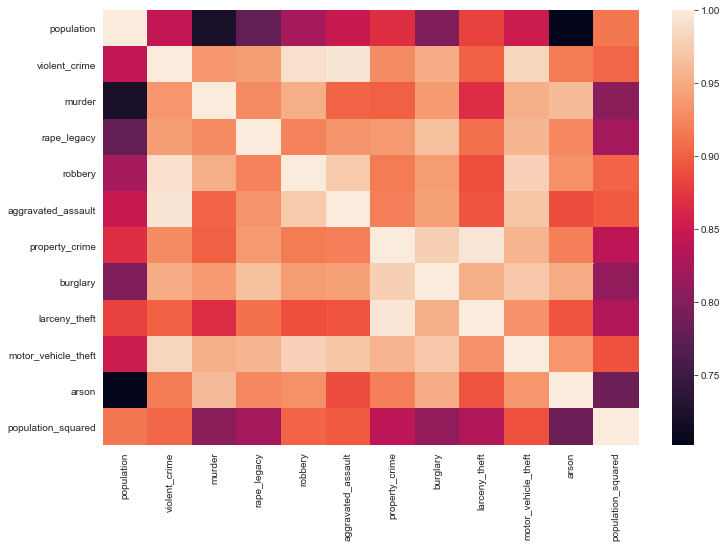

In [94]:
plt.figure(figsize=[12,8])
sns.heatmap(crime.corr())
plt.show()

/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


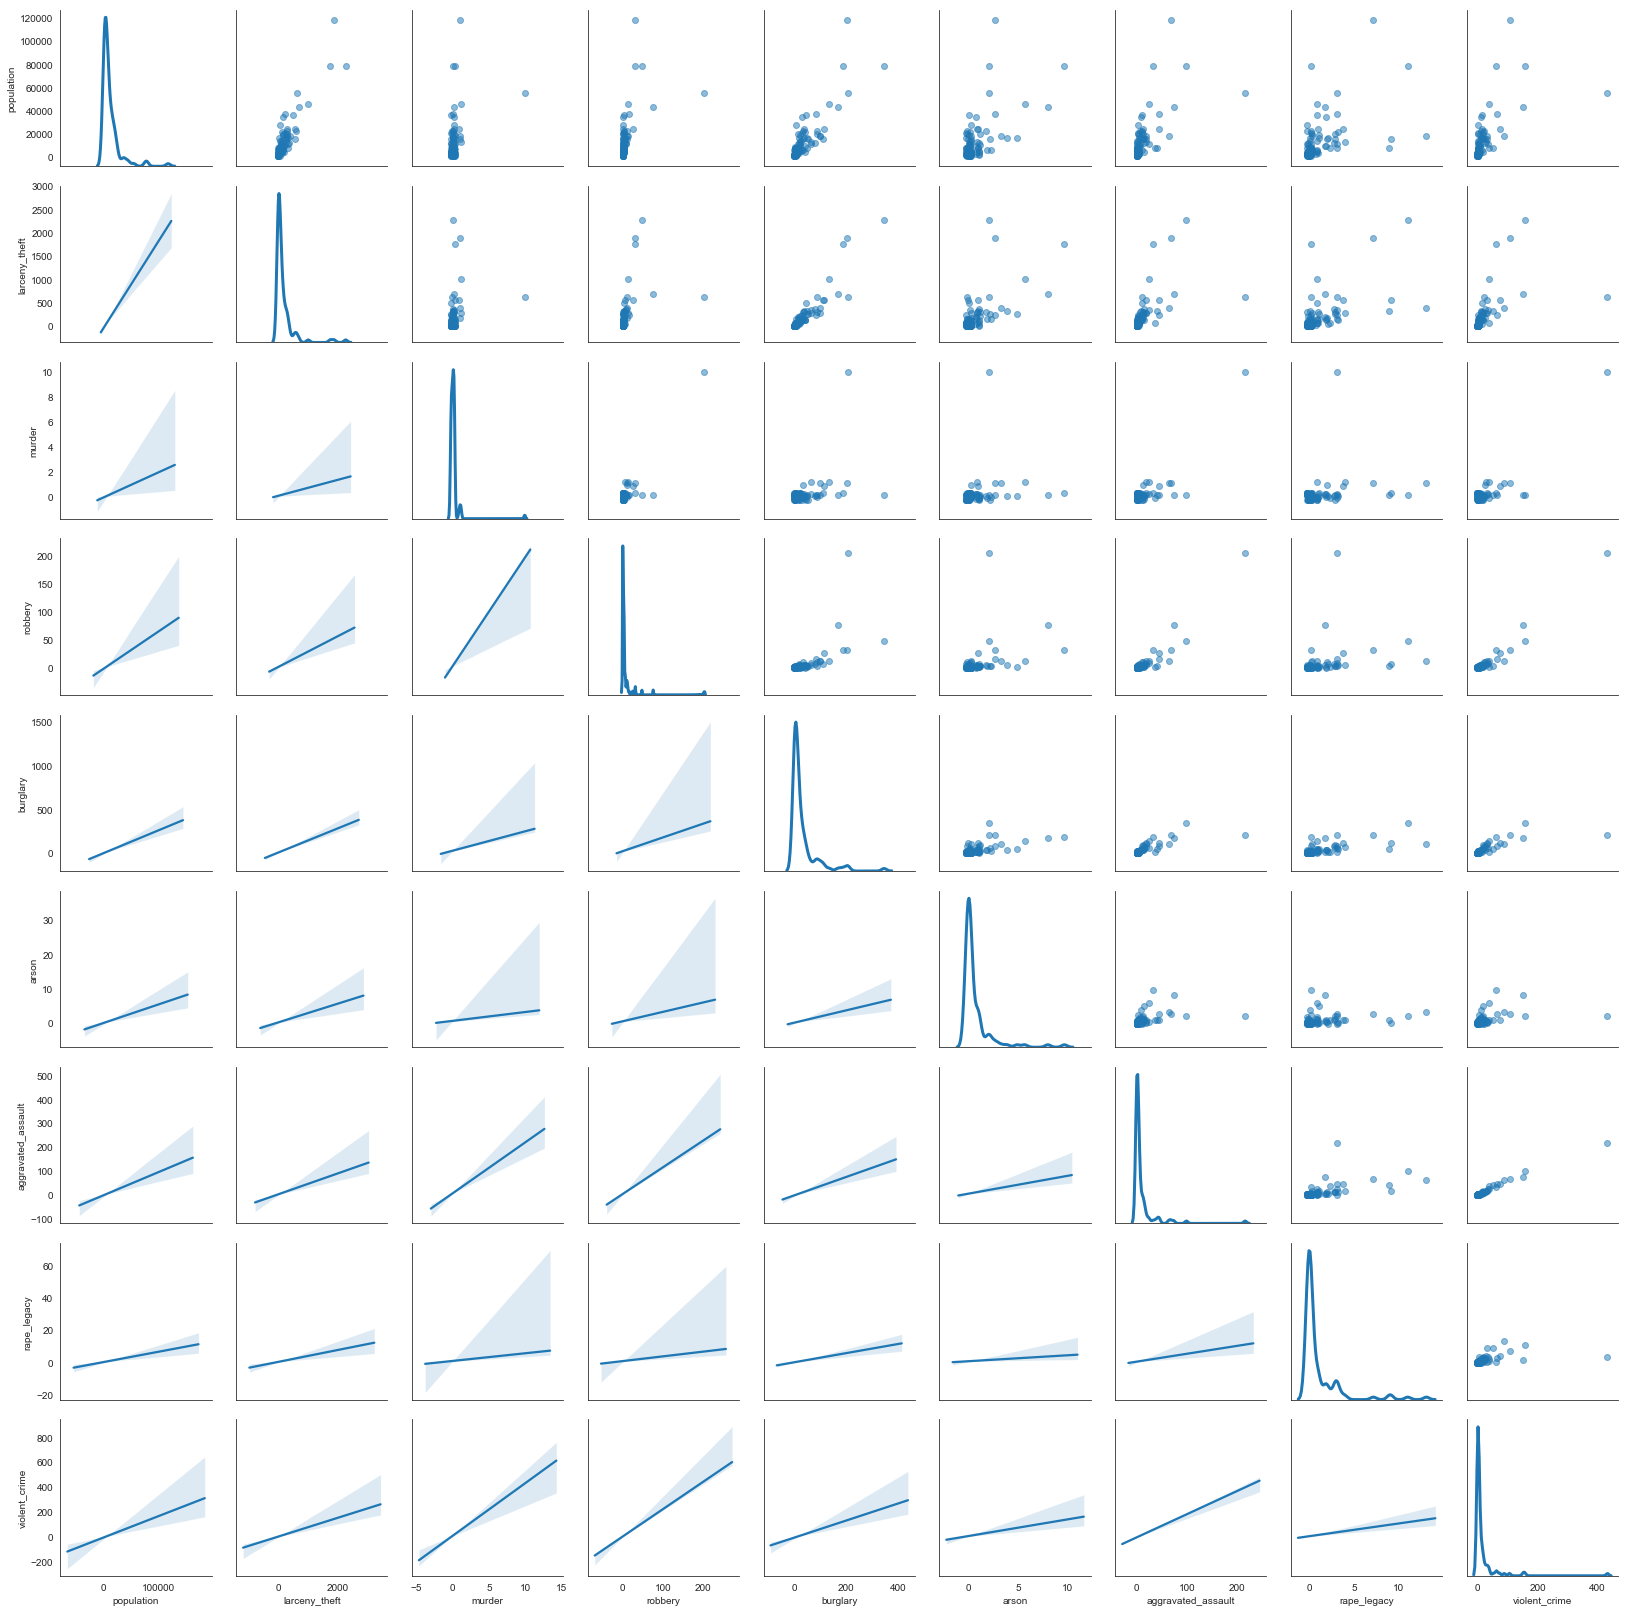

In [95]:
# Make a scatterplot matrix

# Set the default plot aesthetics to be prettier.
sns.set_style("white")

# Take a subset of the data to make plots clearer.
crime_sel = crime[['property_crime', 'population', 'larceny_theft', 
                   'murder', 'robbery','burglary','arson',
                   'aggravated_assault','rape_legacy','violent_crime']]

# Because the variables can only take integer values between 0 and 10, points
# on the scatterplot will hide one another. To better see all the points, we
# create a dataframe of random noise (or "jitter") and add it only when plotting.

# Make a copy of the data to add jitter to and plot.
crime_jittered = crime_sel.loc[:, 'population':'violent_crime'].dropna()

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(crime_jittered.shape)),
    columns=crime_jittered.columns)

# Combine the data and the noise.
crime_jittered = crime_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(crime_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

#Some warnings will show up below because the plot does not include a legend.

In [102]:
x_2013 = crime[['population','larceny_theft','murder',
                'robbery','burglary','arson','aggravated_assault',
                'rape_legacy','violent_crime']]
y_2013 = crime['property_crime']

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(x_2013, y_2013)

# Display the attributes we calculated.
#print('Coefficients: \n', regr.coef_)
#print('Intercept: \n', regr.intercept_)
print('NY 2013 R-qsquared: \n',round(regr.score(x_2013,y_2013),5))

data = x_2013
target = y_2013

regr.fit(data, target).predict(data)
y_pred_2013 = regr.predict(x_2013)

from sklearn.model_selection import cross_val_score
cross_val_2013 = cross_val_score(regr, data, target, cv=10)
print('\n2013 cross validation score: \n{}, +/- {}'.format(round(cross_val_2013.mean(),5),
                                                           round(cross_val_2013.std(),5)))

from sklearn.metrics import mean_squared_error as mse
print('\n2013 MSE:\n', round(mse(y_2013,y_pred_2013),3))
print('2013 rMSE:\n', round(mse( y_2013,y_pred_2013)**.5,3))

# Use train_test_split to create the necessary training and test groups
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.2, random_state=20)
regr.fit(X_train,y_train)
print('\n2013 Train/Test split testing on training sample: \n ', round(regr.score(X_train, y_train),5))
print('2013 Train/Test split with 20% holdout: \n ', round(regr.score(X_test, y_test),5))


NY 2013 R-qsquared: 
 0.99996

2013 cross validation score: 
0.99959, +/- 0.00019

2013 MSE:
 35.176
2013 rMSE:
 5.931

2013 Train/Test split testing on training sample: 
  0.99997
2013 Train/Test split with 20% holdout: 
  0.99948


Looking at the train/test holdout method and cross-validation method we see great stability for the model, it looks like the model is well fit without being overfit or underfit.

# Validating with 2014 NY Crime data
Since the model formulation to date has used the entire New York State 2013 dataset, we'll need to validate it using some of the 2014 crime rates in New York State.

In [108]:
crime_2014 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls', header=4)

crime_2014.columns = ['city', 'population', 'violent_crime', 
                 'murder','rape_revised','rape_legacy',
                 'robbery','aggravated_assault','property_crime',
                 'burglary', 'larceny_theft','motor_vehicle_theft','arson' ]
#crime_2014['population_squared'] = crime.population**2
crime_2014 = crime_2014.drop(columns=['rape_revised'])
crime_2014 = crime_2014.dropna()


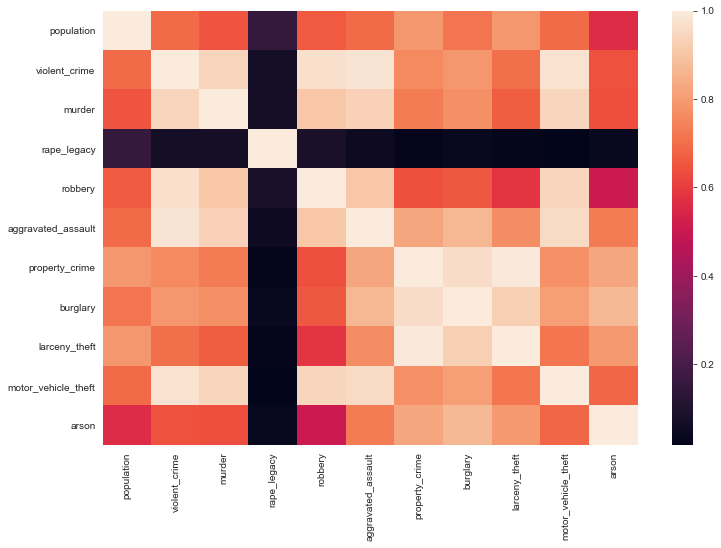

In [104]:
plt.figure(figsize=[12,8])
sns.heatmap(crime_2014.corr())
plt.show()

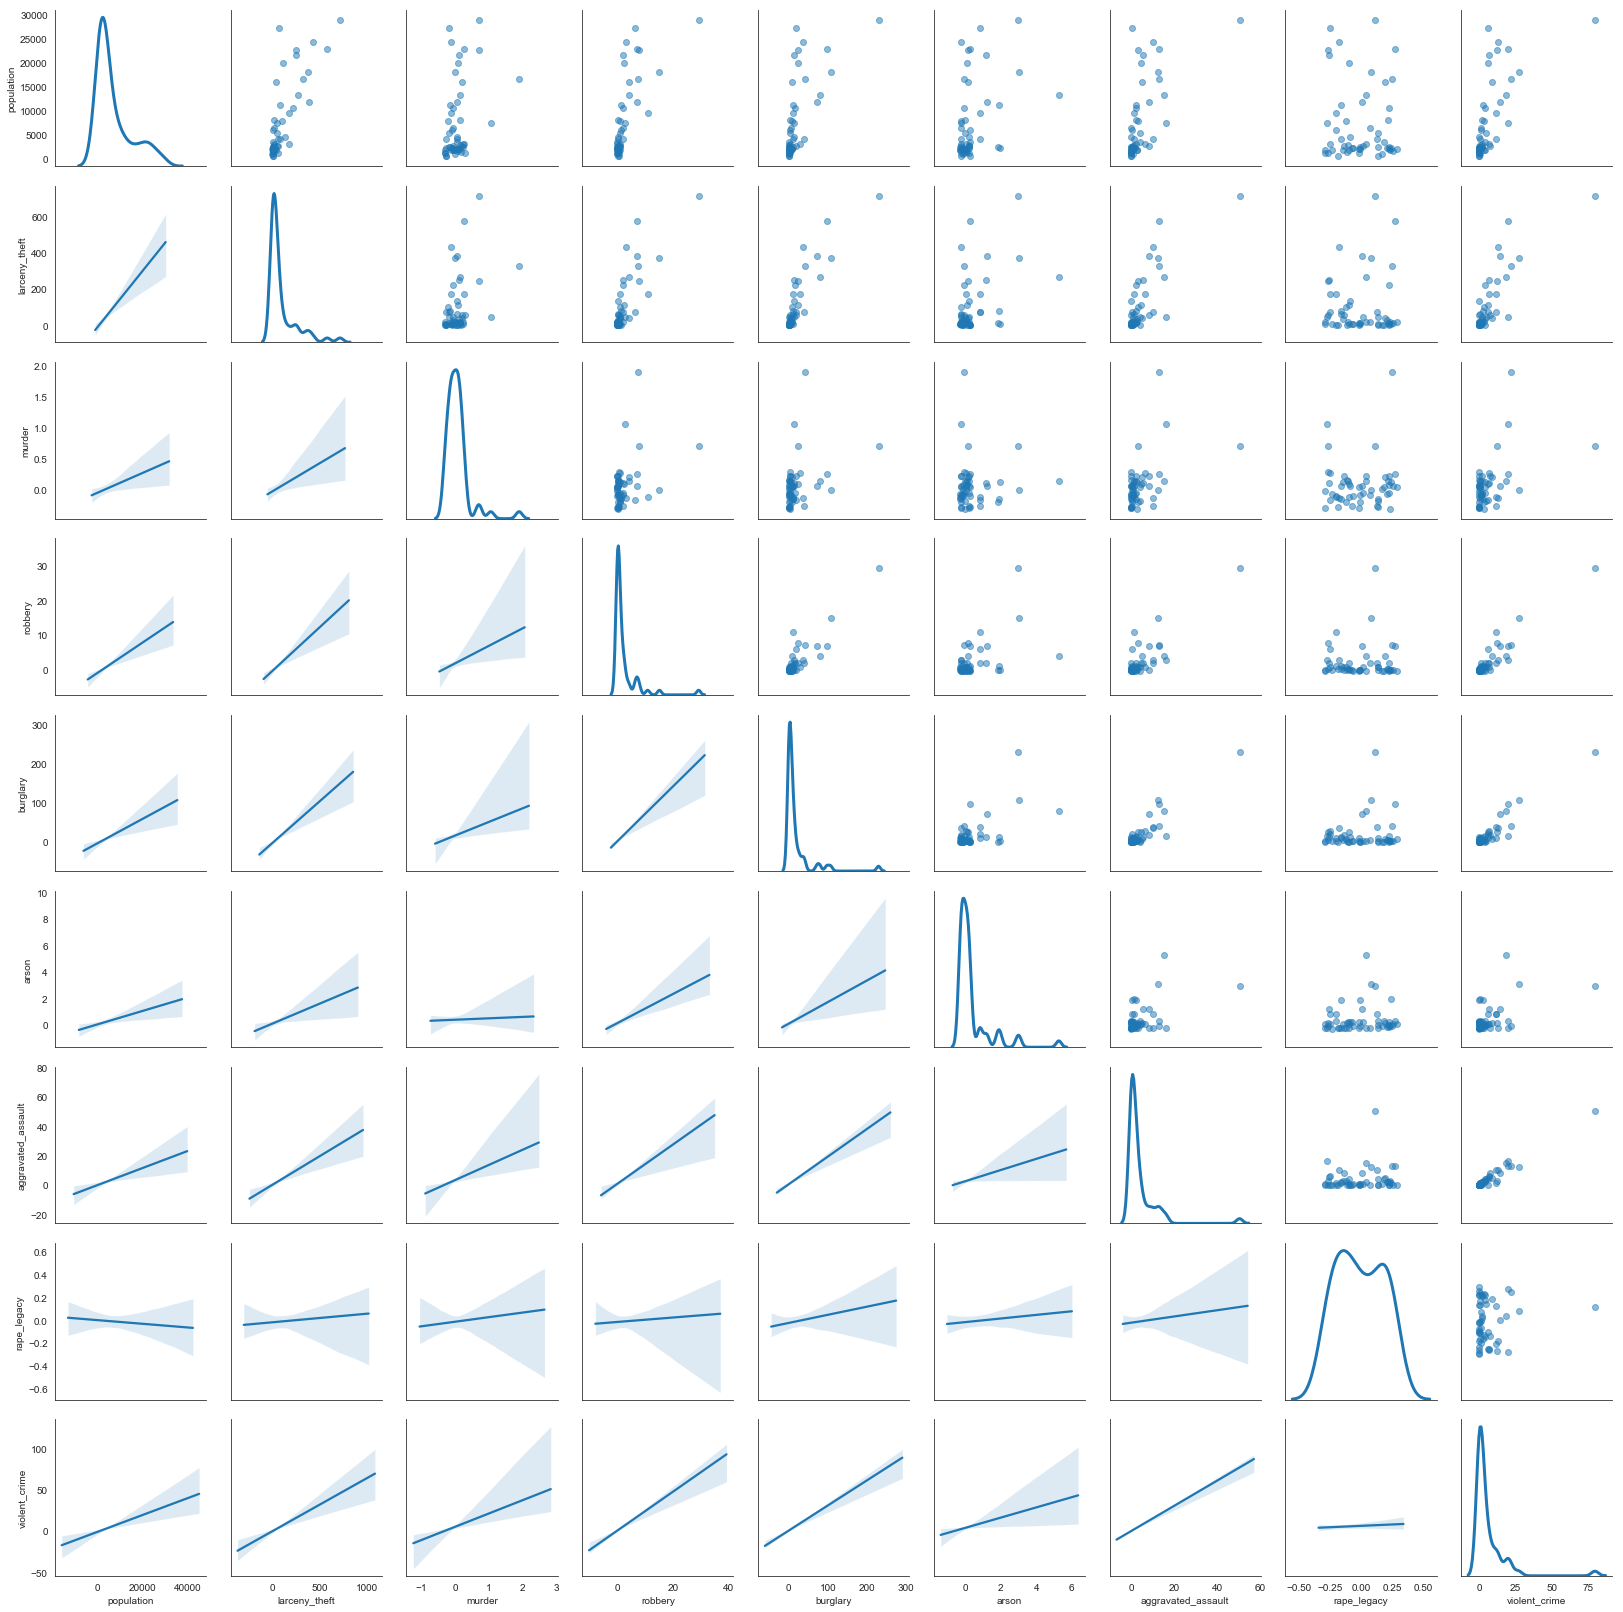

In [107]:
# Make a scatterplot matrix

# Set the default plot aesthetics to be prettier.
sns.set_style("white")

# Take a subset of the data to make plots clearer.
crime_2014_sel = crime_2014[['property_crime', 'population', 'larceny_theft', 
                   'murder', 'robbery','burglary','arson',
                   'aggravated_assault','rape_legacy','violent_crime']]

# Because the variables can only take integer values between 0 and 10, points
# on the scatterplot will hide one another. To better see all the points, we
# create a dataframe of random noise (or "jitter") and add it only when plotting.

# Make a copy of the data to add jitter to and plot.
crime_2014_jittered = crime_2014_sel.loc[:, 'population':'violent_crime'].dropna()

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(crime_2014_jittered.shape)),
    columns=crime_2014_jittered.columns)

# Combine the data and the noise.
crime_2014_jittered = crime_2014_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(crime_2014_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

#Some warnings will show up below because the plot does not include a legend.

In [109]:
x_2014 = crime[['population','larceny_theft','murder',
                'robbery','burglary','arson',
                'aggravated_assault','rape_legacy','violent_crime']]
y_2014 = crime['property_crime']

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(x_2013, y_2013)

data = x_2014
target = y_2014

y_pred_2014 = regr.predict(x_2014)

# Display the validation scores.
print('NY 2014 R-qsquared: \n',round(regr.score(x_2014,y_2014),5))

cross_val_2014 = cross_val_score(regr, data, target, cv=10)
print('\n2014 cross validation score: \n{}, +/- {}'.format(round(cross_val_2014.mean(),5),
                                                           round(cross_val_2014.std(),5)))

print('\n2014 MSE:\n', round(mse(y_2014,y_pred_2014),3))
print('2014 rMSE:\n', round(mse( y_2014,y_pred_2014)**.5,3))

X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.2, random_state=20)
regr.fit(X_train,y_train)
print('\n2014 Train/Test split testing on training sample: \n ', round(regr.score(X_train, y_train),5))
print('2014 Train/Test split with 20% holdout: \n ', round(regr.score(X_test, y_test),5))

NY 2014 R-qsquared: 
 0.99996

2014 cross validation score: 
0.99959, +/- 0.00019

2014 MSE:
 35.176
2014 rMSE:
 5.931

2014 Train/Test split testing on training sample: 
  0.99997
2014 Train/Test split with 20% holdout: 
  0.99948


As our model is fit with the 2013 data, the train/test holdout method and cross-validation method with the 2014 data further confirms the fit of the model suggesting strong predicting power.